In [1]:
!spacy download es_core_news_sm

     ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
     ------------------- -------------------- 6.3/12.9 MB 35.1 MB/s eta 0:00:01
     --------------------------------------- 12.9/12.9 MB 32.3 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


In [2]:
# !pip install spacy

In [3]:
import re
import csv
import json
import pickle
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import spacy
from spellchecker import SpellChecker
spell = SpellChecker(language='es')
nlp = spacy.load('es_core_news_sm') # For lemmatizing the words

In [4]:
import pyLDAvis
import pyLDAvis.lda_model
pyLDAvis.enable_notebook()

In [5]:
bills = pd.read_csv('./Clean/bills.csv')
bills.shape

(742, 10)

In [6]:
bills.head(10)

,Unnamed: 0,number,title,Autores,type_bill,year,period,state_bill,authors_positions,authors_count
0,0,PL331-22,PL 331-23 Seguridad Digital,"['ANA MARÍA CASTAÑEDA GÓMEZ', 'DAVID LUNA SÁNC...",Proyecto de ley,2022-2023,2022 - 2026,archivado,-0.666667,3.0
1,2,PL321-22,PL 321-23 Servicios Aereos,['ALEX JAVIER FLÓREZ HERNÁNDEZ.'],Proyecto de ley,2022-2023,2022 - 2026,archivado,1.000000,1.0
2,3,PL320-22,PL 320-23 Servicio Público de EnergiaDescargar,"['JOSÉ DAVID NAME CARDOZO', 'EDGAR DE JESÚS DÍ...",Proyecto de ley,2022-2023,2022 - 2026,archivado,0.500000,8.0
3,4,PL319-22,PL 319-23 Violencia Vicaria,['NADIA GEORGETTE BLEL SCAFF'],Proyecto de ley,2022-2023,2022 - 2026,archivado,0.000000,1.0
4,5,PL309-22,PL 309-23 Corridas de Toros,"['Ministro de Cultura', 'Dr. JORGE IGNACIO ZOR...",Proyecto de ley,2022-2023,2022 - 2026,ley,0.930233,43.0
5,6,PL308-22,PL 308-23 Ley Cero,"['KARINA ESPINOSA OLIVER', 'OSCAR MAURICIO GIR...",Proyecto de ley,2022-2023,2022 - 2026,archivado,-0.054054,37.0
6,7,PL306-22,PL 306-23 Contraloría,"['JUAN FELIPE LEMOS URIBE', 'EDGAR DE JESÚS DÍ...",Proyecto de ley,2022-2023,2022 - 2026,ley,0.000000,23.0
7,8,PL305-22,PL 305-23 Administraciones Distritales,"['JORGE ELIECER TAMAYO MARULANDA', 'JOSÉ ELIÉC...",Proyecto de ley,2022-2023,2022 - 2026,archivado,0.380952,21.0
8,9,PL304-22,PL 304-23 Medalla Edwin KemmererDescargar,"['JORGE BENEDETTI MARTELO', 'ROY BARRERAS MONT...",Proyecto de ley,2022-2023,2022 - 2026,ley,-0.379310,29.0
9,10,PL302-22,PL 302-23 Contratación,"['HONORIO MIGUEL HENRÍQUEZ PINEDO', 'ENRIQUE C...",Proyecto de ley,2022-2023,2022 - 2026,archivado,-1.000000,14.0


In [7]:
# Read all the txt files in the folder and put them in an array in the order specified
# Returns also only the titles it found
def get_bills_text(bills_path, file_names):
  bills_txt = []
  names_found = []
  for bill in file_names:
    try:
      with open(bills_path + '/' + bill + '_ocr.txt', 'r', encoding="utf8") as f:
          text = f.read()
          if len(text) > 500:
              bills_txt.append(text)
              names_found.append(bill)
    except FileNotFoundError:
      print(f"File {bill}_ocr.txt not found.")
  return bills_txt, names_found

In [8]:
file_names = bills['title'].values
    # Read all the txt files in the folder and put them in an array in the order specified
texts, bills_found = get_bills_text('./Raw/Bills_txt', file_names)
labels_df = bills[bills['title'].isin(bills_found)].copy()
labels_df.reset_index(drop=True, inplace=True)
print(labels_df.shape, len(texts))

File PL-284S-2023--196C-2022 Honores SalentoDescargar _ocr.txt not found.
File PL-271S-2022 Derecho a la gestion comunitaria del  agua_ocr.txt not found.
File PL-234 Convención interamericana contra toda forma de discriminación e intolerancia_ocr.txt not found.
File PL-231 Servicio público domiciliario esencial de gas natural en nuevas viviendas de interés social VIS y viviendas de interés prioritario VIP_ocr.txt not found.
File PL-225 Trabajador Bananero_ocr.txt not found.
File PL-224 Perros guia_ocr.txt not found.
File PL-223 Participacion de los jovenes_ocr.txt not found.
File PL-206 Divorcio_ocr.txt not found.
File PL-200 Canales de comercializacion para pequeños y medianos productores_ocr.txt not found.
File PL-199 Patrimonio Cultural Encuentro Nacional del Tiple - Envigado_ocr.txt not found.
File PL-189 Honores Jose Maria Cordoba_ocr.txt not found.
File PL-181 Politica de paz de estado_ocr.txt not found.
File PL-090 Protesta social_ocr.txt not found.
File PL 042-23 Hurto_ocr.txt 

In [9]:
texts[435]

'ATAN concreto:r.\nDELA REUBICAS.\n5 de: Dicotomía el es - el JUAN DIEGO ECHEVARRÍA SÁNCHEZ SENADOR PROYECTO DE LEY OS 2023 SENADO Por medio del cual se establecen los criterios voluntarios de gobernanza y democratización en la educación superior y se dictan otras disposiciones El Congreso de la República DECRETA ARTÍCULO 1.\nOBJETO.\nLa presente ley tiene por objeto establecer los criterios voluntarios de gobernanza y democratización en las Instituciones de Educación Superior.\nARTÍCULO 2.\nPRINCIPIOS, Las reglas de interpretación y aplicación de la presente ley se soportan en los siguientes principios: a ca, en AUTONOMÍA UNIVERSITARIA: las instituciones de educación superior tienen las garantías constitucionales de autodeterminación ideológica y administrativa conformé sus 1 propios estatutos.\nCULTURA DE RENDICIÓN DE CUENTAS: es la acción de informar de manera periódica, planeada y participativa a los grupos de interés los objetivos cumplidos y no cumplidos.\nPARTICIPACIÓN DEMOCRÁTI

In [10]:
# https://github.com/Alir3z4/stop-words/blob/master/spanish.txt
# Get stop words
stop_words = ['artículo', 'ley', 'congreso', 'cámara', 'senado', 'representantes', 'senador', 'senadora', 'ministerio', 'partido', 'político',
              'representante', 'colombia', 'república', 'edificio', 'calle', 'carrera', 'padilla', 'oficina', 'paloma', 'esmeralda', 'general',
              'teléfono', 'piso', 'proyecto', 'nacional', 'país', 'nación', 'html', 'www', 'com', 'co', 'gov', 'presente', 'parágrafo', 'secretario',
              'información', 'congresista', 'página', 'interés', 'objeto', 'aplicar', 'copia', 'medio', 'ministro', 'honorable', 'cordialmente',
              'respetuosamente', 'pacto', 'histórico', 'alianza', 'verde', 'centro', 'democrático', 'entrada' 'vigencia', 'marco', 'normativo',
             'entrada', 'vigencia', 'legislativo', 'legislativa', 'forma', 'específico', 'resto', 'formalmente', 'beneficio', 'actual', 'efectivamente',
             'atentamente', 'impacto', 'discusión', 'votación', 'consanguinidad', 'afinidad', 'civil', 'permanente', 'grado', 'compañera', 'compañero', 
              'compañera', 'cónyuge', 'favor', 'particular', 'situación', 'carácter', 'iniciativa', 'agosto', 'doctor', 'fecha', 'promulgación',
             'señor', 'presidente', 'mes', 'año', 'trámite', 'creer', 'privilegio', 'personal', 'inmediatio', 'legislador', 'fuente', 'asunto', 
              'conocido', 'decreto', 'sentencia', 'correo', 'electrónico', 'único', 'exclusivamente', 'capítulo', 'título']
print(len(stop_words))
with open('./Raw/spanish.txt', 'r', encoding="utf8") as f:
    for line in f:
        stop_words.append(line.strip())
response = requests.get('https://raw.githubusercontent.com/Alir3z4/stop-words/refs/heads/master/spanish.txt')
response.raise_for_status()
stop_words += response.text.splitlines()
print(len(stop_words))
# cleaning the names and last names that may appear in the text (congresspeople's names and heads of other entities)
# https://github.com/olea/lemarios/blob/master/nombres-propios-es.txt
# https://github.com/olea/lemarios/blob/master/apellidos-es.txt
response = requests.get('https://raw.githubusercontent.com/olea/lemarios/refs/heads/master/nombres-propios-es.txt')
response.raise_for_status()
stop_words += response.text.splitlines()
print(len(stop_words))
response = requests.get('https://raw.githubusercontent.com/olea/lemarios/refs/heads/master/apellidos-es.txt')
response.raise_for_status() 
stop_words += response.text.splitlines()
len(stop_words)

109
1325
1780


1883

In [11]:
def check_word(word):
    return word.lower() not in spell.unknown([word])

In [12]:
def lemmatize_words(text, stop_words):
    words = text.split(' ')
    lemmatized = []
    for word in words:
        if word not in stop_words and check_word(word):  # Check if the word exists in spanish or is a mistake from OCR or a typo or a stop word
            doc = nlp(word)
            if len(doc) > 0:
                lemmatized.append(doc[0].lemma_)
    return lemmatized

In [13]:
def text_preprocessing(texts, stop_words):
    text_cln = []
    for text in tqdm(texts):
        text = re.sub(r'[\W\d_]+', ' ', text.strip().lower())
        text_cln.append(' '.join(lemmatize_words(text, stop_words)))
        # text_cln.append(text)
    return text_cln

In [14]:
import os
if os.path.isfile("text_cln.pkl"):
    with open("text_cln.pkl", 'rb') as f:
        text_cln = pickle.load(f)
else:
    text_cln = text_preprocessing(texts, stop_words)
len(text_cln)

719

In [15]:
# Save the array to a pickle file
with open("text_cln.pkl", "wb") as f:
    pickle.dump(text_cln, f)

38


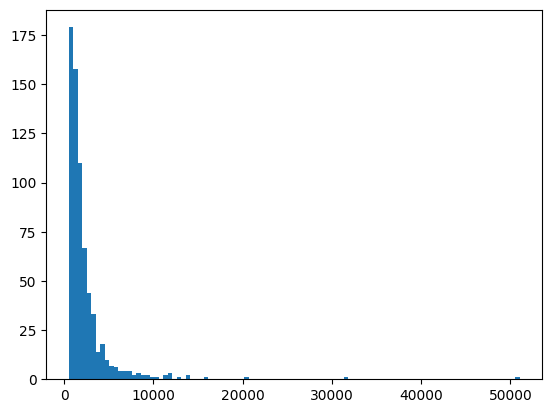

In [16]:
doc_lens = [len(doc.split()) for doc in text_cln]
print(len([dl for dl in doc_lens if dl < 500]))

plt.hist([dl for dl in doc_lens if dl > 500], bins=100) 
plt.show()

In [17]:
text_cln[129][:500]

'rey procedimiento jurisdicción especial paz radicar procedimiento jurisdicción especial paz respectivo maría cabal dirección correo electrónico maría coma puro david enrique baquero asar valencia caserna pinedir andrés guerra suceder vicente castro dirección correo electrónico procedimiento jurisdicción especial paz modificar procedimiento jurisdicción especial paz libro título participación procedimiento calidad víctima recepción caso grupo sala sección respectivo sala reconocimiento persona ma'

In [18]:
tfidf_vect = TfidfVectorizer(min_df=0.05, max_df=0.80, stop_words=stop_words, ngram_range=(2, 2), sublinear_tf=False, strip_accents=None)
tfidf = tfidf_vect.fit_transform(text_cln)
tfidf.shape

C:\Users\Daniel Cardenas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aarón', 'abdón', 'abel', 'abelardo', 'abrahán', 'absalón', 'acacio', 'adalberto', 'adela', 'adelaida', 'adolfo', 'adrián', 'adán', 'adón', 'aguilar', 'agustín', 'aitor', 'alba', 'albert', 'alberto', 'albina', 'alejandra', 'alejandro', 'alejo', 'alfonso', 'alfredo', 'alicia', 'alipio', 'almudena', 'alonso', 'amadeo', 'amaro', 'ambrosio', 'amelia', 'amparo', 'ana', 'ananías', 'anastasia', 'anatolio', 'andrea', 'andrés', 'aniano', 'anna', 'anselmo', 'antero', 'antonia', 'antonio', 'aquiles', 'araceli', 'arcadio', 'aresio', 'ariadna', 'arias', 'aristides', 'arnaldo', 'artemio', 'arturo', 'aránzazu', 'ascensión', 'asunción', 'atanasio', 'augusto', 'aurelia', 'aureliano', 'aurelio', 'aurora', 'baldomero', 'balduino', 'baltasar', 'bartolomé', 'basileo', '

(719, 1139)

# K-Means

In [19]:
labels = KMeans(init='k-means++', n_clusters=3, random_state=0, n_init=100).fit_predict(tfidf)

In [20]:
k_range = range(3,30)
inertia = []
silhouette = []

for i in k_range:
    km_i = KMeans(init='k-means++', n_clusters=i, max_iter=100000,
                  random_state=0, n_init=100)
    inertia.append(km_i.fit(tfidf).inertia_)
    silhouette.append(silhouette_score(tfidf, km_i.fit_predict(tfidf), metric='cosine'))

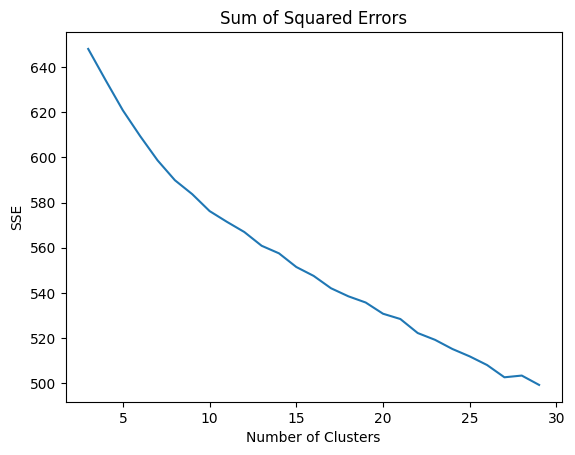

In [21]:
plt.plot(k_range, inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.title('Sum of Squared Errors')
plt.show()

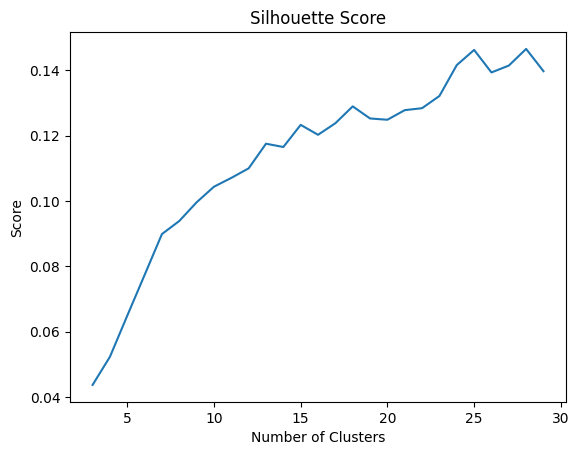

In [22]:
plt.plot(k_range, silhouette)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Silhouette Score')
plt.show()

In [23]:
arr = np.array(labels)
unique, counts = np.unique(arr, return_counts=True)

print(dict(zip(unique, counts)))

{np.int32(0): np.int64(98), np.int32(1): np.int64(569), np.int32(2): np.int64(52)}


# LDA

In [24]:
search_params = {
  'n_components': [3, 4, 5, 10, 15, 20, 25],
  'learning_decay': [.5, .7]
}
# Set up LDA with the options we'll keep static
model = LatentDirichletAllocation(learning_method='online', random_state=14)

# Try all of the options
gridsearch = GridSearchCV(model, param_grid=search_params, n_jobs=-1, verbose=1)
gridsearch.fit(tfidf)
    
# What did we find?
print("Best Model's Params: ", gridsearch.best_params_)
print("Best Log Likelihood Score: ", gridsearch.best_score_)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
Best Model's Params:  {'learning_decay': 0.7, 'n_components': 3}
Best Log Likelihood Score:  -8144.340554638463


In [25]:
LDA = LatentDirichletAllocation(random_state=14, learning_method='online', learning_decay=0.7, 
                                n_components=gridsearch.best_params_['n_components'])

In [26]:
theta = LDA.fit_transform(tfidf)
theta.shape

(719, 3)

In [27]:
max_index = np.argmax(theta[:, 1])
text_cln[max_index][:200]

'concreto plata julio presentación incentivo creación educación medio confor yo previsto consideración incentivo creación educación medio motivo anexo documento original digital digital plata grano con'

In [28]:
beta = LDA.components_
beta.shape

(3, 1139)

In [29]:
topic_saliency = theta.sum(axis=0) / theta.sum()
topic_saliency

array([0.62019174, 0.24055551, 0.13925275])

In [30]:
# review top words
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " | ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message, '\n')
    print()

In [31]:
features = tfidf_vect.get_feature_names_out()
print_top_words(model=LDA, feature_names = features, n_top_words = 20)

Topic #0: corte constitucional | seguridad social | protección social | desarrollo rural | salud protección | salud público | américo latino | salud mental | derecho fundamental | conflicto armado | fuerza público | especial protección | elección popular | calidad vida | prestación servicio | conservador colombiano | sistema seguridad | valle cauca | acuerdo final | ordenamiento jurídico 

Topic #1: educación superior | patrimonio cultural | corte constitucional | servicio público | mediano plazo | fiscal mediano | municipio departamento | crédito público | hacienda crédito | educación básico | compatibilidad fiscal | sistema educativo | barrera función | calidad educación | departamento magdalena | análisis fiscal | gasto público | acceso educación | balance principio | mostrar incompatible 

Topic #2: ambiente desarrollo | bienestar animal | cambio climático | maltrato animal | protección animal | protección bienestar | ambiente sano | fauna silvestrar | protección ambiente | efecto 

In [32]:
def plot_top_words(model, feature_names, n_top_words, topic_saliency, title):
    fig, axes = plt.subplots(1, len(topic_saliency), figsize=(30, 15), sharex=False)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        topic_dist = topic / topic.sum()  
        top_features_ind = topic_dist.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic_dist[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}\n({round(topic_saliency[topic_idx]*100, 2)}% of docs)", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

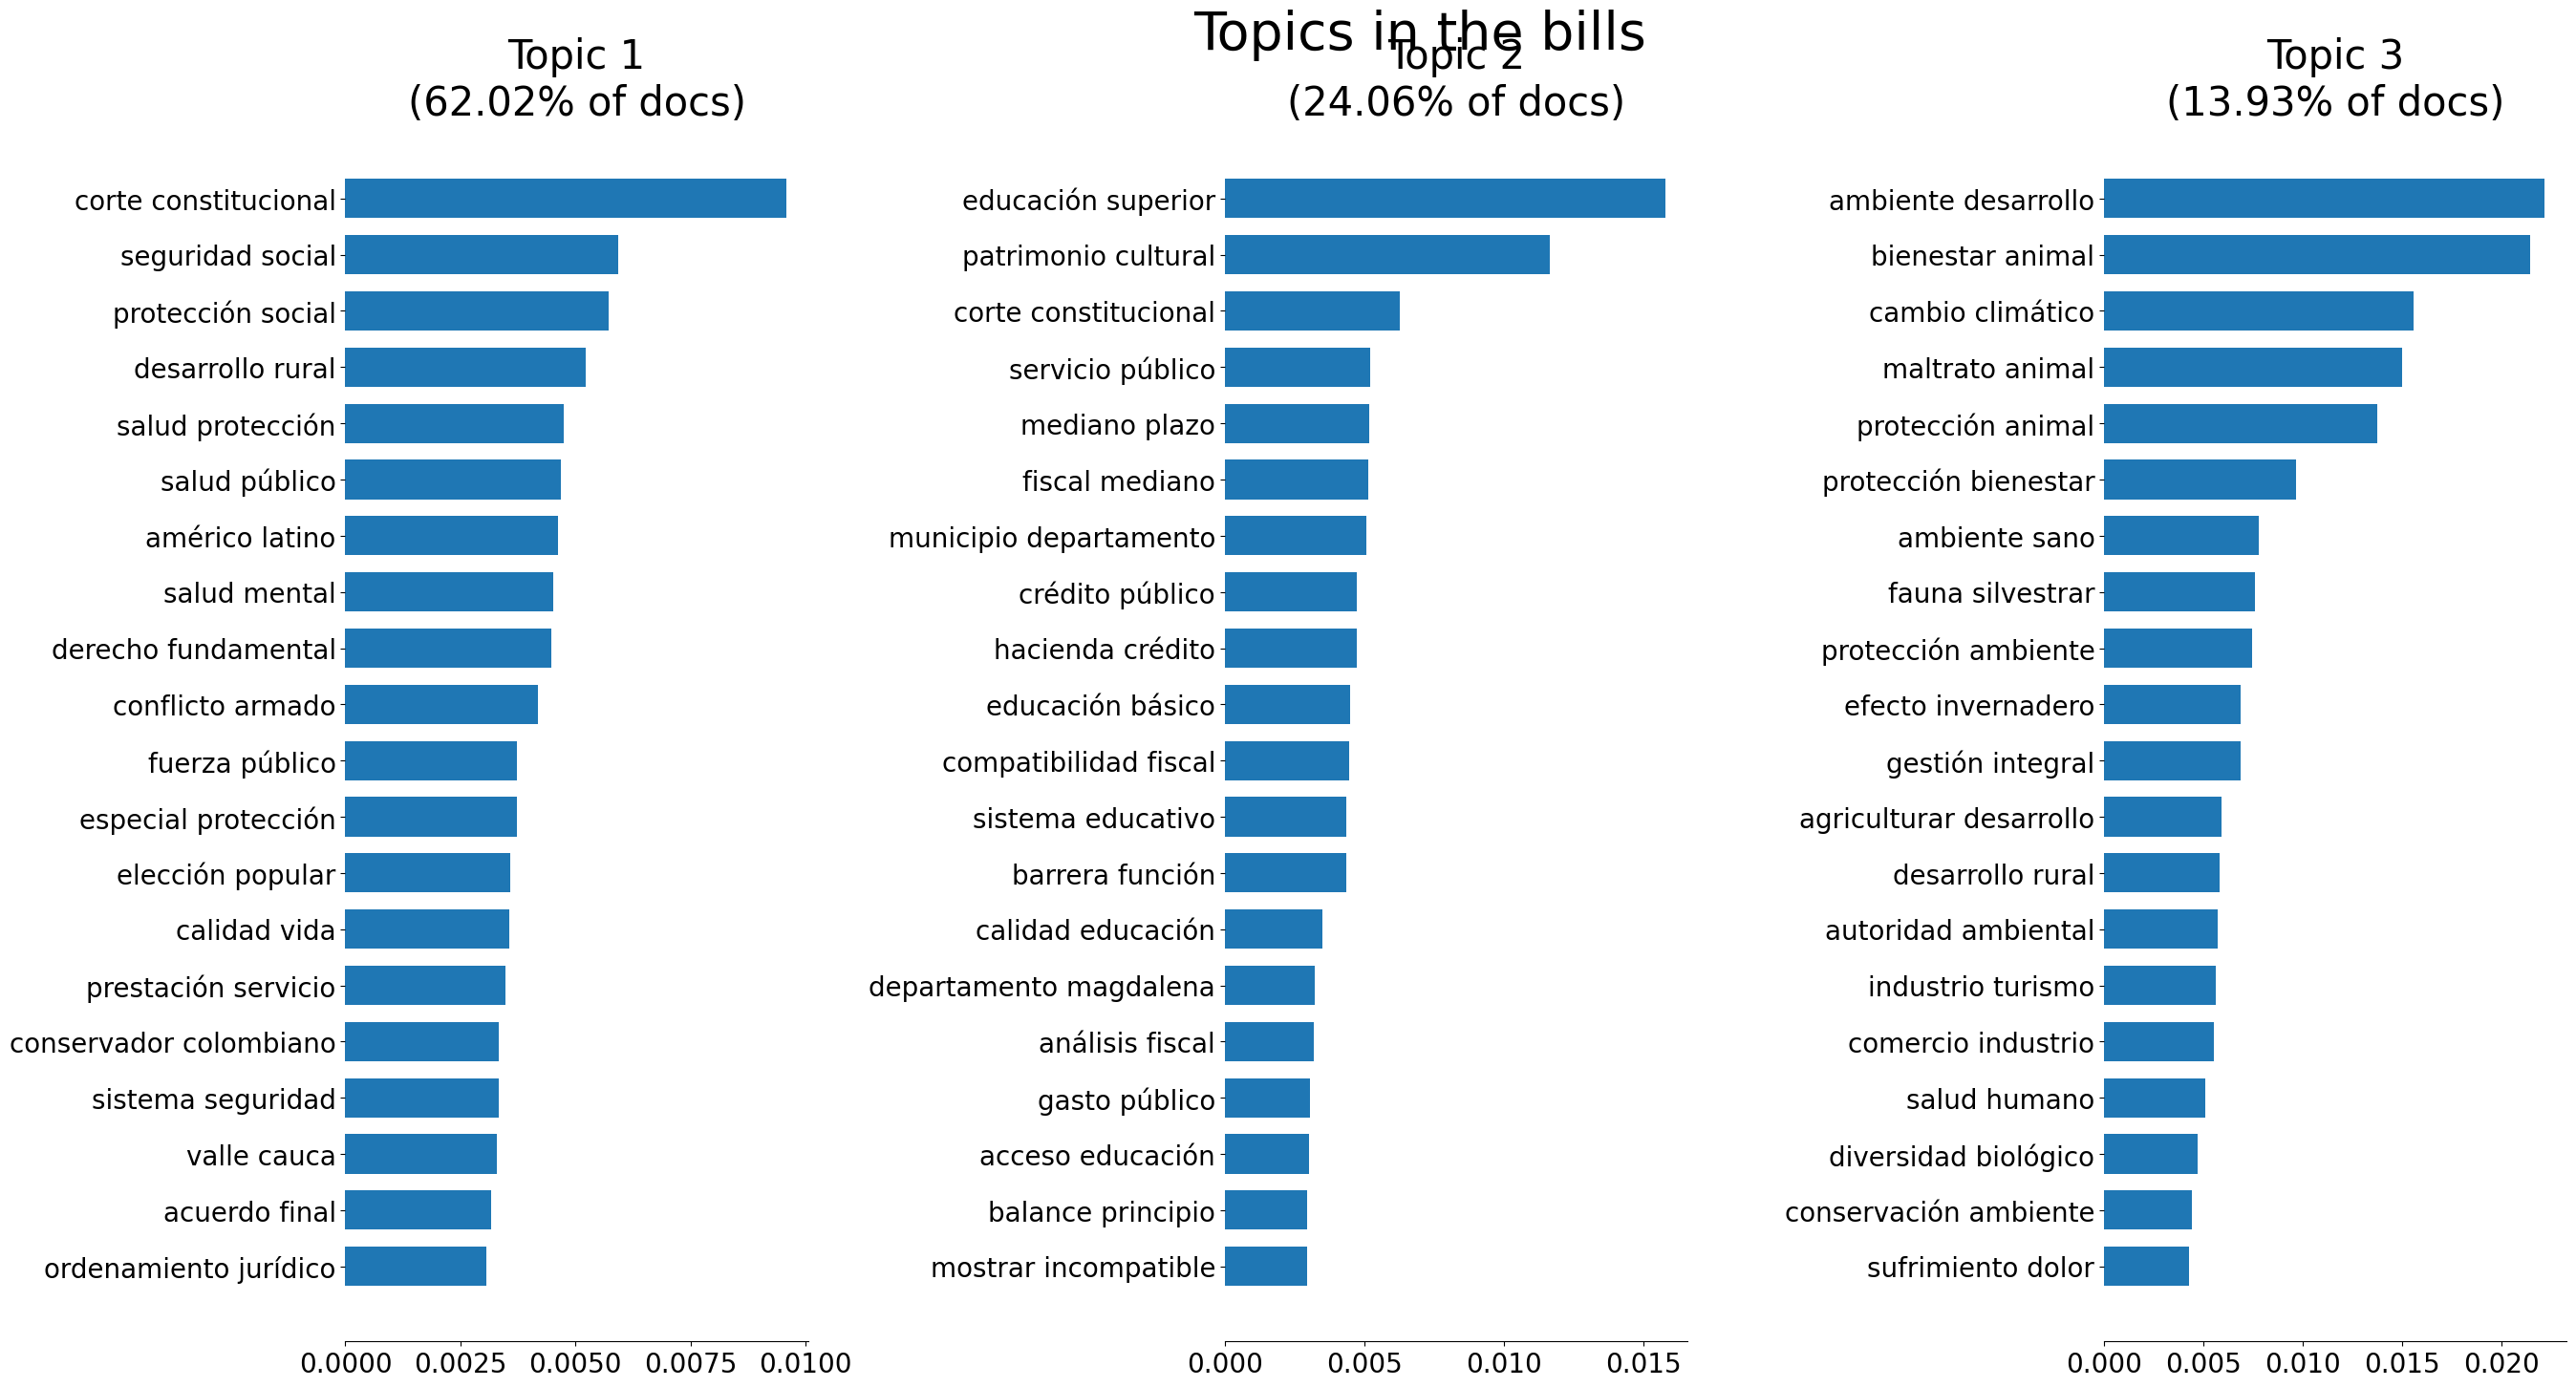

In [33]:
plot_top_words(model=LDA, feature_names = features, topic_saliency=topic_saliency, n_top_words = 20, title='Topics in the bills')

In [34]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.lda_model.prepare(LDA, tfidf, tfidf_vect)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.068276  0.074050       1        1  58.504389
1     -0.119181  0.007563       2        1  28.118767
2      0.050905 -0.081613       3        1  13.376844, topic_info=                        Term       Freq      Total Category  logprob  loglift
63       ambiente desarrollo  15.000000  15.000000  Default  30.0000  30.0000
107         bienestar animal  13.000000  13.000000  Default  29.0000  29.0000
424       educación superior  26.000000  26.000000  Default  28.0000  28.0000
125         cambio climático  11.000000  11.000000  Default  27.0000  27.0000
674          maltrato animal  10.000000  10.000000  Default  26.0000  26.0000
...                      ...        ...        ...      ...      ...      ...
859       producción consumo   2.239564   4.224367   Topic3  -5.6170   1.3771
801              plan acción   2.511975   5.920203   Topic3  -5.5022   1.1543
353         desarrollo rural   3.563149  18.567179   Topic3  -5.1526   0.3609
204   conservador colombiano   2.154786  11.917070   Topic3  -5.6556   0.3014
1006            santo martar   2.069117   6.002067   Topic3  -5.6961   0.9467

[172 rows x 6 columns], token_table=      Topic      Freq                    Term
term                                         
7         1  0.427009        acceso educación
7         2  0.569345        acceso educación
21        2  0.936934  aceptar interpretación
31        1  0.984412           acuerdo final
35        1  0.968058             acuerdo paz
...     ...       ...                     ...
1111      1  0.804736             valle cauca
1111      2  0.089415             valle cauca
1111      3  0.178830             valle cauca
1114      2  0.936568          veto ejecutivo
1127      1  0.888789        violencia sexual

[218 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

In [35]:
pyLDAvis.save_html(vis, 'LDAvis.html')

# Label values

In [36]:
labels_df

,Unnamed: 0,number,title,Autores,type_bill,year,period,state_bill,authors_positions,authors_count
0,0,PL331-22,PL 331-23 Seguridad Digital,"['ANA MARÍA CASTAÑEDA GÓMEZ', 'DAVID LUNA SÁNC...",Proyecto de ley,2022-2023,2022 - 2026,archivado,-0.666667,3.0
1,2,PL321-22,PL 321-23 Servicios Aereos,['ALEX JAVIER FLÓREZ HERNÁNDEZ.'],Proyecto de ley,2022-2023,2022 - 2026,archivado,1.000000,1.0
2,3,PL320-22,PL 320-23 Servicio Público de EnergiaDescargar,"['JOSÉ DAVID NAME CARDOZO', 'EDGAR DE JESÚS DÍ...",Proyecto de ley,2022-2023,2022 - 2026,archivado,0.500000,8.0
3,4,PL319-22,PL 319-23 Violencia Vicaria,['NADIA GEORGETTE BLEL SCAFF'],Proyecto de ley,2022-2023,2022 - 2026,archivado,0.000000,1.0
4,5,PL309-22,PL 309-23 Corridas de Toros,"['Ministro de Cultura', 'Dr. JORGE IGNACIO ZOR...",Proyecto de ley,2022-2023,2022 - 2026,ley,0.930233,43.0
...,...,...,...,...,...,...,...,...,...,...
714,779,AL035-22,PAL 35-22 Jurisdicción Agraria,"['Ministro del Interior - Alfonso Prada Gil', ...",Acto legislativo,2022-2023,2022 - 2026,acto,0.812500,32.0
715,780,AL040-22,PAL 40-22 Senados Regionales,"['Jorge Méndez Hernández', ' Carlos Alberto Cu...",Acto legislativo,2022-2023,2022 - 2026,archivado,-0.705882,17.0
716,781,AL038-22,PAL 38-22 Superintendencia de Educacion,"['Jorge Eliécer Tamayo Marulanda', ' Teresa De...",Acto legislativo,2022-2023,2022 - 2026,archivado,-0.083333,24.0
717,782,AL037-22,PAL 37-22 MODIFICAN LOS ARTÍCULOS 356 Y 357 DE...,"['Olga Lucia Velásquez Nieto', ' Elkin Rodolfo...",Acto legislativo,2022-2023,2022 - 2026,archivado,0.882353,17.0


In [37]:
labels_df['topic_1'] = theta[:,1]
labels_df['topic_2'] = theta[:,0]
labels_df['topic_3'] = theta[:,2]
labels_df

,Unnamed: 0,number,title,Autores,type_bill,year,period,state_bill,authors_positions,authors_count,topic_1,topic_2,topic_3
0,0,PL331-22,PL 331-23 Seguridad Digital,"['ANA MARÍA CASTAÑEDA GÓMEZ', 'DAVID LUNA SÁNC...",Proyecto de ley,2022-2023,2022 - 2026,archivado,-0.666667,3.0,0.063047,0.872883,0.064070
1,2,PL321-22,PL 321-23 Servicios Aereos,['ALEX JAVIER FLÓREZ HERNÁNDEZ.'],Proyecto de ley,2022-2023,2022 - 2026,archivado,1.000000,1.0,0.897443,0.070561,0.031996
2,3,PL320-22,PL 320-23 Servicio Público de EnergiaDescargar,"['JOSÉ DAVID NAME CARDOZO', 'EDGAR DE JESÚS DÍ...",Proyecto de ley,2022-2023,2022 - 2026,archivado,0.500000,8.0,0.751294,0.172753,0.075953
3,4,PL319-22,PL 319-23 Violencia Vicaria,['NADIA GEORGETTE BLEL SCAFF'],Proyecto de ley,2022-2023,2022 - 2026,archivado,0.000000,1.0,0.049920,0.895482,0.054598
4,5,PL309-22,PL 309-23 Corridas de Toros,"['Ministro de Cultura', 'Dr. JORGE IGNACIO ZOR...",Proyecto de ley,2022-2023,2022 - 2026,ley,0.930233,43.0,0.052784,0.675610,0.271605
...,...,...,...,...,...,...,...,...,...,...,...,...,...
714,779,AL035-22,PAL 35-22 Jurisdicción Agraria,"['Ministro del Interior - Alfonso Prada Gil', ...",Acto legislativo,2022-2023,2022 - 2026,acto,0.812500,32.0,0.041078,0.917734,0.041188
715,780,AL040-22,PAL 40-22 Senados Regionales,"['Jorge Méndez Hernández', ' Carlos Alberto Cu...",Acto legislativo,2022-2023,2022 - 2026,archivado,-0.705882,17.0,0.063442,0.871646,0.064913
716,781,AL038-22,PAL 38-22 Superintendencia de Educacion,"['Jorge Eliécer Tamayo Marulanda', ' Teresa De...",Acto legislativo,2022-2023,2022 - 2026,archivado,-0.083333,24.0,0.875550,0.071392,0.053058
717,782,AL037-22,PAL 37-22 MODIFICAN LOS ARTÍCULOS 356 Y 357 DE...,"['Olga Lucia Velásquez Nieto', ' Elkin Rodolfo...",Acto legislativo,2022-2023,2022 - 2026,archivado,0.882353,17.0,0.042925,0.916533,0.040542


In [38]:
labels_df['topic_1_positions'] = labels_df['topic_1'] * labels_df['authors_positions']
labels_df['topic_2_positions'] = labels_df['topic_2'] * labels_df['authors_positions']
labels_df['topic_3_positions'] = labels_df['topic_3'] * labels_df['authors_positions']
labels_df

,Unnamed: 0,number,title,Autores,type_bill,year,period,state_bill,authors_positions,authors_count,topic_1,topic_2,topic_3,topic_1_positions,topic_2_positions,topic_3_positions
0,0,PL331-22,PL 331-23 Seguridad Digital,"['ANA MARÍA CASTAÑEDA GÓMEZ', 'DAVID LUNA SÁNC...",Proyecto de ley,2022-2023,2022 - 2026,archivado,-0.666667,3.0,0.063047,0.872883,0.064070,-0.042031,-0.581922,-0.042713
1,2,PL321-22,PL 321-23 Servicios Aereos,['ALEX JAVIER FLÓREZ HERNÁNDEZ.'],Proyecto de ley,2022-2023,2022 - 2026,archivado,1.000000,1.0,0.897443,0.070561,0.031996,0.897443,0.070561,0.031996
2,3,PL320-22,PL 320-23 Servicio Público de EnergiaDescargar,"['JOSÉ DAVID NAME CARDOZO', 'EDGAR DE JESÚS DÍ...",Proyecto de ley,2022-2023,2022 - 2026,archivado,0.500000,8.0,0.751294,0.172753,0.075953,0.375647,0.086377,0.037977
3,4,PL319-22,PL 319-23 Violencia Vicaria,['NADIA GEORGETTE BLEL SCAFF'],Proyecto de ley,2022-2023,2022 - 2026,archivado,0.000000,1.0,0.049920,0.895482,0.054598,0.000000,0.000000,0.000000
4,5,PL309-22,PL 309-23 Corridas de Toros,"['Ministro de Cultura', 'Dr. JORGE IGNACIO ZOR...",Proyecto de ley,2022-2023,2022 - 2026,ley,0.930233,43.0,0.052784,0.675610,0.271605,0.049102,0.628475,0.252656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
714,779,AL035-22,PAL 35-22 Jurisdicción Agraria,"['Ministro del Interior - Alfonso Prada Gil', ...",Acto legislativo,2022-2023,2022 - 2026,acto,0.812500,32.0,0.041078,0.917734,0.041188,0.033376,0.745659,0.033466
715,780,AL040-22,PAL 40-22 Senados Regionales,"['Jorge Méndez Hernández', ' Carlos Alberto Cu...",Acto legislativo,2022-2023,2022 - 2026,archivado,-0.705882,17.0,0.063442,0.871646,0.064913,-0.044782,-0.615279,-0.045821
716,781,AL038-22,PAL 38-22 Superintendencia de Educacion,"['Jorge Eliécer Tamayo Marulanda', ' Teresa De...",Acto legislativo,2022-2023,2022 - 2026,archivado,-0.083333,24.0,0.875550,0.071392,0.053058,-0.072963,-0.005949,-0.004421
717,782,AL037-22,PAL 37-22 MODIFICAN LOS ARTÍCULOS 356 Y 357 DE...,"['Olga Lucia Velásquez Nieto', ' Elkin Rodolfo...",Acto legislativo,2022-2023,2022 - 2026,archivado,0.882353,17.0,0.042925,0.916533,0.040542,0.037875,0.808706,0.035772


In [39]:
labels_df[['topic_1_positions', 'topic_2_positions', 'topic_3_positions']].to_csv('bills_topic_positions.csv')

In [40]:
import pickle
with open("lda.pkl", "wb") as f:
    pickle.dump(LDA, f)
with open("tfidf_vect.pkl", "wb") as f:
    pickle.dump(tfidf_vect, f)
with open("tfidf.pkl", "wb") as f:
    pickle.dump(tfidf, f)
with open("topic_positions", "wb") as f:
    pickle.dump(labels_df[['topic_1_positions', 'topic_2_positions', 'topic_3_positions']], f)

In [41]:
round(float(np.mean([1,2,3,4])),2)

2.5